In [1]:
from os import listdir
import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


def data_extractor(path, category):
    data = []
    for file in sorted(listdir(path)):
        name = file.split("-")
        model = name[1]
        if (category == (name[-1].split("."))[0]):
            values = list(pd.read_csv(join(path, file))["Value"])
            data.append((model, values))
    return data

In [2]:
from matplotlib.ticker import MaxNLocator

categories = { "train" : ("train_accy", "train_loss"), 
               "valid" : ("valid_accy", "valid_loss")}

def harry_plotter(stage, experiment, title=""):
    bottom = 1.5 if stage == "valid" else -0.1
    top = 7. if stage == "valid" else 3.
    fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
    for i, cosa in enumerate(categories.get(stage)):
        data = data_extractor(f"data/pruebas/{experiment}", cosa)
        for (label, values) in data:
            epochs = np.arange(len(values)) + 1
            ax[i].plot(epochs, values, label=label)
        ax[i].legend()
        ax[i].set_xlabel('Época')
        ax[i].set_ylabel(cosa.split("_")[-1])
        ax[i].grid()
        ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    if (ax[1].get_ylim()[1] > 7.):
        ax[1].set_ylim(bottom, top)
    fig.suptitle(f"{title}\n{stage}")
    plt.show()

# Escogiendo la arquitectura

```python
np.random.seed(0)
torch.manual_seed(0)
```

Comparamos el desempeño de los modelos pre-entrenados mas pequeños? de resNet en nuestro dataset de entrenamiento. Este conjunto se separó en dos subconjuntos, uno con un 85% del tamaño original para entrenar y la fracción restante para validar. Se congelaron todas las capas y se reemplazó la cabeza clasificadora de modo que la salida se acomode a nuestro problema (10 clases).

En todos los casos se usó `adam` como optimizador con una tasa de aprendizaje de 1e-3 y `CrossEntropyLoss` como función de costo.

```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
```

También se incluye el desempeño de `squeezenet1_1` que se probó en primera instancia.

<IPython.core.display.Javascript object>


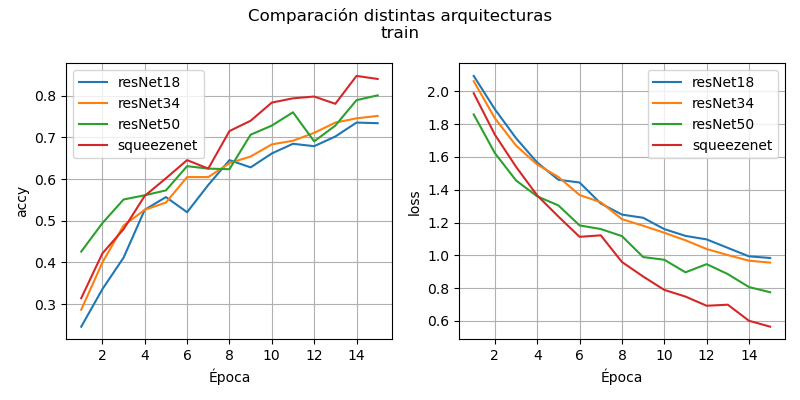

In [6]:
harry_plotter("train", "modelos", "Comparación distintas arquitecturas")

<IPython.core.display.Javascript object>


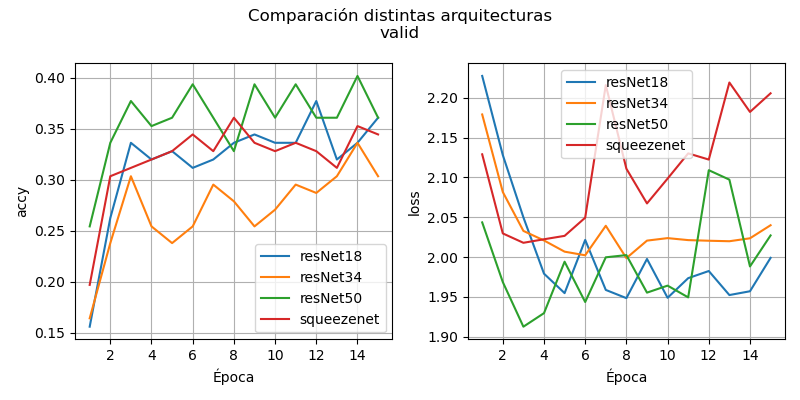

In [7]:
harry_plotter("valid", "modelos", "Comparación distintas arquitecturas")

Sin hacer cambios a los modelos pre-entrenados observamos que `resNet50` tiene el mejor desempeño en validación, tanto en accuracy como en loss. Vemos que `squeezenet` se sobreajusta rápidamente a los datos con un buen rendimiento en entrenamiento pero con una loss de validación que empieza a aumentar tras unas pocas épocas. De las tres versiones de resNet, `resNet34` nos entrega los peores resultados en validación.

Debido a lo observado, seleccionamos `resNet50` para entrenar nuestro modelo final.

<IPython.core.display.Javascript object>


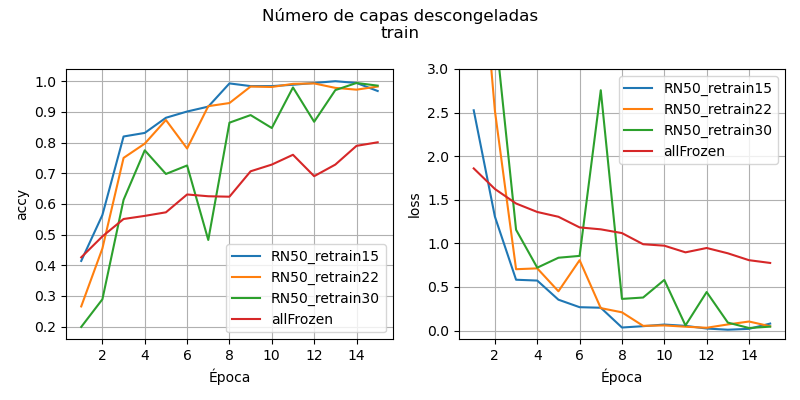

In [10]:
harry_plotter("train", "capas", "Número de capas descongeladas")

<IPython.core.display.Javascript object>


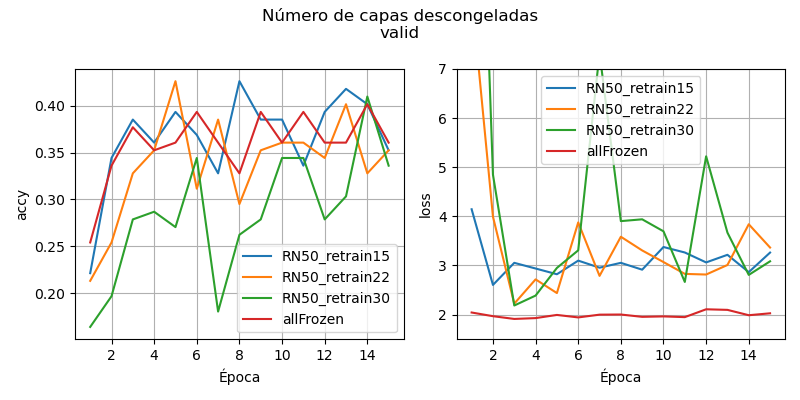

In [11]:
harry_plotter("valid", "capas", "Número de capas descongeladas")

 Al descongelar cierto número de capas convolucionales de resNet50 notamos que los modelos se sobreajustan rápidamente a nuestros datos. Optamos por trabajar descongelando las últimas 15 capas para tener un modelo un poco más complejo, pero que pueda aprender filtros relacionados con features específicas de las piezas de arte, con un rendimiento potencial mayor al momento de utilizarlo en el conjunto de prueba. 
 
 Intentaremos incorporar medidas para enfrentar el sobreajuste...